# Logistic Regression

## Learning goals

1. Compare predicting a continuous outcome to predicting a class
2. Compare linear to logistic regression as classification models
3. Describe how logistic regression works under the hood
4. Learn how to interpret a trained logistic model's coefficients
5. Familiarize ourselves with Maximum Likelihood Estimation
6. Explore the C (inverse regularization) paramater and hyperparameter tune
7. Learn how to adjust the threshold of a logistic model
8. Describe the assumptions of linear regression

In [1]:
from src.student_caller import three_random_students, one_random_student
from src.student_list import student_first_names

# Why logistic 1st of our classifiers?

Approximately 70% of problems in Data Science are classification problems. There are lots of classification algorithms that are available, but the logistics regression is common and is a useful regression method for solving the binary classification problem.


Logistic regression takes a concept we are familiar with, a linear equation, and translates it into a form fit for predicting a class.  

It generally can't compete with the best supervised learning algorithms, but it is **simple, fast, and interpretable**.  

As we will see in mod 4, it will also serve as a segue into our lessons on **neural nets**.

# 1. Compare predicting a continuous outcome to predicting a class

Thus far, we have worked to predict continuous target variables using linear regression. 

  - Continous target variables:
        - Sales price of a home
        - MPG of a car
        - A Country's Life Expectancy Rate
        
We will now transition into another category of prediction: classification. Instead of continous target variables, we will be predicting whether records from are data are labeled as a particular class.  Whereas the output for the linear regression model can be any number, the output of our classification algorithms can only be a value designated by a set of discrete outcomes.

  - Categorical target variables:
        - Whether an employee will stay at a company or leave (churn)
        - Whether a tumor is cancerous or benign
        - Whether a flower is a rose, a dandelion, a tulip, or a daffodil
        - Whether a voter is Republican, Democrat, or Independent



Let's navigate to the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table), and browse there classification datasets.  Which one's catch your eye?

![discuss](https://media.giphy.com/media/l0MYIAUWRmVVzfHag/giphy.gif)

In [84]:
three_random_students(student_first_names)

['Karim' 'Sam' 'Matthew']


### We are still dealing with **labeled data**.

![labels](https://media.giphy.com/media/26Ff5evMweBsENWqk/giphy.gif)


This is still supervised learning. 

But now, instead of the label being a continuous value, such as house price, the label is the category.  This can be either binary or multiclass.  But we still need the **labels** to train our models.



# 2. Compare linear to logistic regression as classification models


The goal of logistic regression, and any classification problem, is to build a model which accurately separates the classes based on independent variables.  

We are already familiar with how linear regression finds a best-fit "line".  It uses the **MSE cost function** to minimize the difference between true and predicted values.  

A natural thought would be to use that "line" to descriminate between classes: Everything with an output greater than a certain point is classified as a 1, everything below is classified as a 0.

In this way, logistic classifer is **parametric, discriminitive** function.  The best fit parameters ($\beta$)s creates a decision boundary which allows us to discriminate between the classes.

![decision_boundary](https://www.researchgate.net/publication/325813999/figure/fig5/AS:638669773893635@1529282148432/Classification-decision-boundary-using-logistic-regression-The-blue-area-corresponds-to.png)

In [249]:
#img source https://www.researchgate.net/publication/325813999/figure/fig5/AS:638669773893635@1529282148432/Classification-decision-boundary-using-logistic-regression-The-blue-area-corresponds-to.png


# Breast Cancer Dataset

Logistic regression "is widely used in biostatistical applications where binary responses (two classes) occur quite frequently. For example, patients survive
or die, have heart disease or not, or a condition is present or absent."   [Elements of Statistical Learning, Ch. 4, p. 119](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12_toc.pdf)


[data_source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

In [88]:
# Breast Cancer identification dataset
import pandas as pd

df = pd.read_csv('data/breast_cancer.csv', index_col= 0)

df.drop(columns= ['Unnamed: 32'], inplace = True)


In [89]:
df['Target'] = df.diagnosis.map(lambda x: 1 if x == 'M' else 0)

In [90]:
df.Target.value_counts()

0    357
1    212
Name: Target, dtype: int64

We have a fairly **balanced dataset**.  The logistic regression model will likely be able to pick up on the signal of the minority class.  If it were heavily imbalanced, our model might predict only the majority class, and we would have to use resampling techniques to pick up on the signal.

To begin exploring how logistic regression works, we will fit a linear regression model, and using techniques we know, make predictions.

# Individual Exercise (turn off camera, take 2 minutes)

- Use 'area_mean' as the independent variable and 'Target' as dependent variable and apply a linear regression model to this dataset.


In [99]:
# Your code here
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

y_hat = None # Continuous prediction here

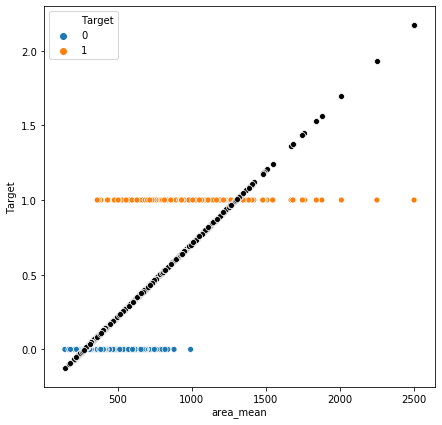

In [101]:
# Plot the resulting regression line.
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(df.area_mean, df.Target, hue=df.Target)
sns.scatterplot(df.area_mean, list(y_hat),color='black')



- According to the linear regression model, that would be your prediction if area_mean = 350?

- What about if 'area_mean' is 5?

- What about 2000?

In [102]:
import numpy as np

Those predictions are not within the bounds of our target's sample space. In fact, linear regression could produce predictions from **-$\infty$ to $\infty$**  


In order to fix that, we can set a threshold which determines a 0 or 1 value.
Let's set the threshhold at .5.

In [105]:
lr_prd = (y_hat > .5).astype(int)
df['lr_yhat'] = lr_prd

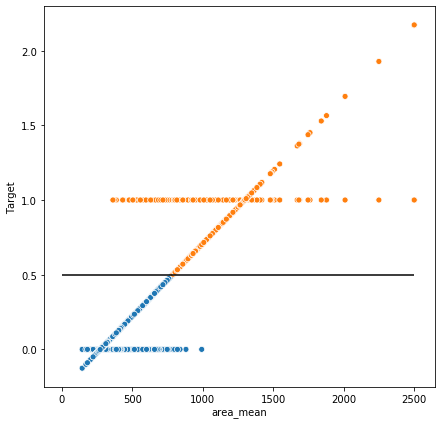

In [106]:
# Now, let's plot again


fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(df.area_mean, df.Target, hue=df.Target)
sns.scatterplot(df.area_mean, list(y_hat), hue=df.lr_yhat)
ax.hlines(.5, xmin=0, xmax=2500)
ax.get_legend().remove();

Let's look at how many predictions linear regression got wrong.

In [107]:
print(f"Linear Regression missed {(df.Target != df.lr_yhat).sum()} predictions")

Linear Regression missed 82 predictions


In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lin = confusion_matrix(df.Target, df.lr_yhat)
cm_lin

array([[351,   6],
       [ 76, 136]])

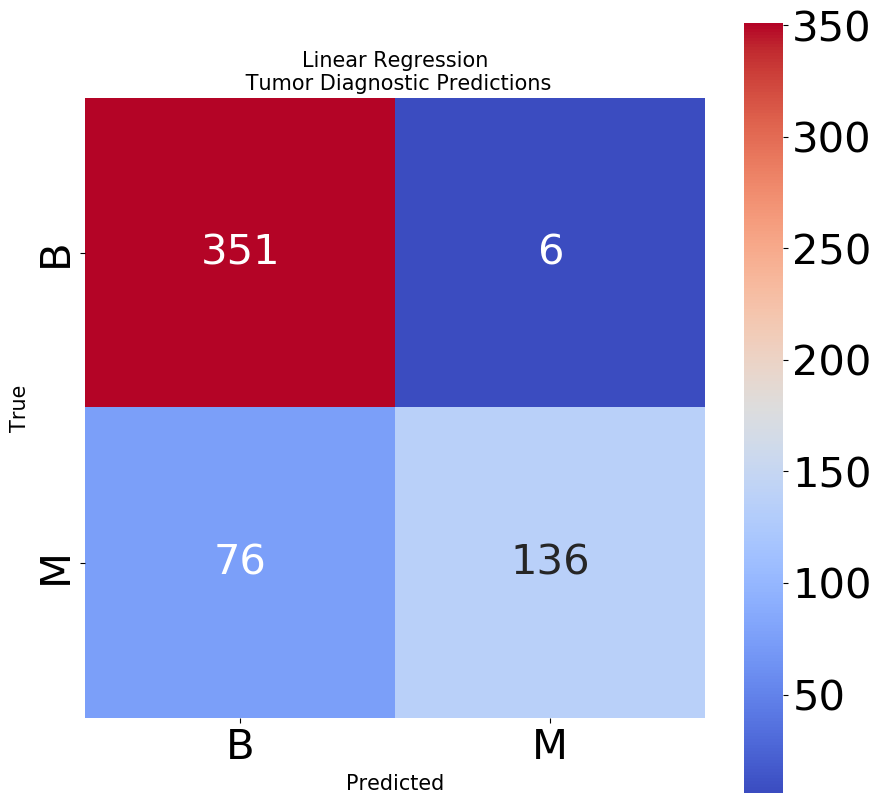

In [165]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cm_lin, annot=True, ax=ax, square=True, cmap="coolwarm", fmt='g', xticklabels=['B', 'M'],yticklabels=['B', 'M'] )
plt.rcParams.update({'font.size': 30})
ax.set_xlabel('Predicted', fontdict={'size': 15})
ax.set_ylabel('True', fontdict={'size': 15})
ax.set_title('Linear Regression\n Tumor Diagnostic Predictions', fontdict={'size': 15} )
plt.show()

# Now Let's Try Logistic Regression

In [154]:
# Note: Same module as Linear Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='none', solver='lbfgs')
log_reg.fit(df[['area_mean']], df[['Target']])
yhat_log = log_reg.predict(df[['area_mean']])
yhat_log_proba = log_reg.predict_proba(df[['area_mean']])

df['yhat_log_proba'] = yhat_log_proba[:,1]
df['yhat_log'] = yhat_log
df.head()


/Users/johnmaxbarry/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Target,lr_yhat,yhat_log_proba,yhat_log
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,1,0.978233,1
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,1,0.999514,1
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,1,0.997939,1
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,0,0.031361,0
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,1,0.999317,1


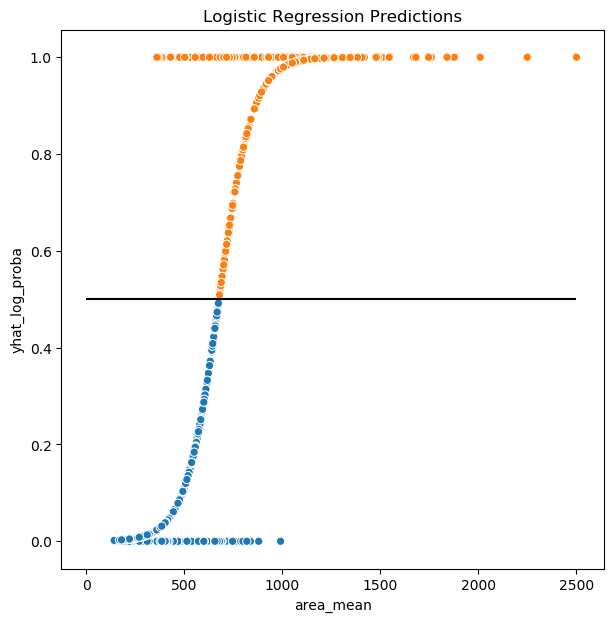

In [156]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(df.area_mean, df.Target, hue=df.Target)
sns.scatterplot(df.area_mean, df.yhat_log_proba, hue=df.yhat_log)
ax.hlines(.5, xmin=0, xmax=2500)
ax.get_legend().remove()
ax.set_title('Logistic Regression Predictions')
plt.style.use(['default']);

__Your Turn__

Use the trained logistic regression and make predictions for 

- area_mean = 350
- area_mean = 5
- area_mean = 2000

In [16]:
# Your code here

Logistic regression's predict function automatically converts the predicted probabilities to categorical predctions.
To return the probabilities, use the predict_proba method.

In [18]:
log_reg.predict_log_proba([[5], [350],[2000]])

array([[-3.65219872e-04, -7.91519360e+00],
       [-2.09500013e-02, -3.87607329e+00],
       [-1.55608578e+01, -1.74584373e-07]])

In [19]:
# What does the above output mean?
one_random_student(student_first_names)

Hunter


How did our logistic regression model compare with our linear regression?

In [157]:
print(f"Logistic Regression missed {(df.Target != df.yhat_log).sum()} predictions")

Logistic Regression missed 66 predictions


In [158]:
# Let's look at how many differences there were between our two predictions
(df.lr_yhat != df.yhat_log).sum()

44

In [159]:
lr_logr_diffs = df[(df.lr_yhat != df.yhat_log) & (df.lr_yhat == df.Target)]
print(lr_logr_diffs.shape[0])

14


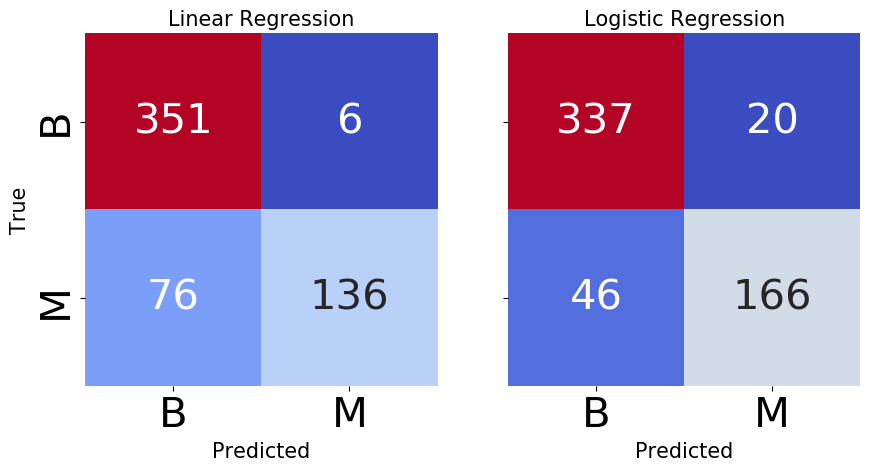

<Figure size 640x480 with 0 Axes>

In [186]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))

# Linear Regression Confusion Matrix
sns.heatmap(cm_lin, annot=True, ax=ax1,cbar=False, square=True, 
            cmap="coolwarm", fmt='g', xticklabels=['B', 'M'],yticklabels=['B', 'M'] )
plt.rcParams.update({'font.size': 30})
ax1.set_xlabel('Predicted', fontdict={'size': 15})
ax1.set_ylabel('True', fontdict={'size': 15})
ax1.set_title('Linear Regression', fontdict={'size': 15} )


# Logistic Regression Confusion Matrix
cm_log = confusion_matrix(df.Target, df.yhat_log)
sns.heatmap(cm, annot=True, ax=ax2,  square=True, 
            cbar=False, cmap="coolwarm", fmt='g',
            xticklabels=['B', 'M'],yticklabels=['', ''] )

ax2.set_xlabel('Predicted', fontdict={'size': 15})

ax2.set_title('Logistic Regression', fontdict={'size': 15} )
plt.show()
plt.tight_layout();

# Threshold

By default, the predict() method applies a threshold of .05 to our prediction probabilities.

In [201]:
# We see that converting all values of the column associated with the probability of a class 1 (Malignant)
# is equal to the output of the predict() method
(log_reg.predict_proba(df[['area_mean']])[:,1] > .5).astype(int) == log_reg.predict(df[['area_mean']])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

However, we may want to be more conservative in our estimate. With medical diagnostics in particular, certain errors are more important to catch.

Which errors have particularly negative consequences in the scenario above?

In [202]:
one_random_student(student_first_names)

Jonathan


To err on the side of caution, we can force our model to predict more conservitavely.  

By lowering the threshold from .5, our model will predict more positive values, thereby decreasing our false negatives.  Consequently, our false positive rate will go up.

In [209]:
# Code here
yhat_lower_thresh = None

In [211]:
cm_lower_thresh = confusion_matrix(df.Target, yhat_lower_thresh)

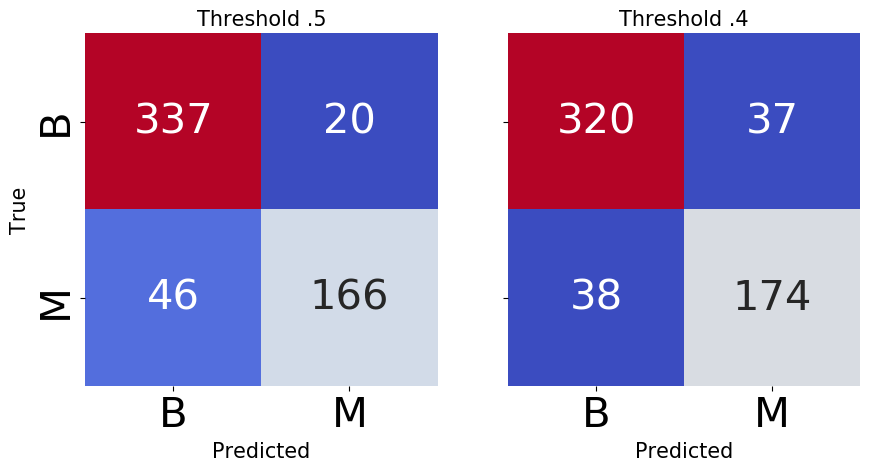

<Figure size 640x480 with 0 Axes>

In [212]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))

# Linear Regression Confusion Matrix
sns.heatmap(cm_log, annot=True, ax=ax1,cbar=False, square=True, 
            cmap="coolwarm", fmt='g', xticklabels=['B', 'M'],yticklabels=['B', 'M'] )
plt.rcParams.update({'font.size': 30})
ax1.set_xlabel('Predicted', fontdict={'size': 15})
ax1.set_ylabel('True', fontdict={'size': 15})
ax1.set_title('Threshold .5', fontdict={'size': 15} )


# Logistic Regression Confusion Matrix
cm_log = confusion_matrix(df.Target, df.yhat_log)
sns.heatmap(cm_lower_thresh, annot=True, ax=ax2,  square=True, 
            cbar=False, cmap="coolwarm", fmt='g',
            xticklabels=['B', 'M'],yticklabels=['', ''] )

ax2.set_xlabel('Predicted', fontdict={'size': 15})

ax2.set_title('Threshold .4', fontdict={'size': 15} )
plt.show()
plt.tight_layout();

# 3. Logistic Regression Under the Hood

As we have seen above, linear regression outputs a value that can range anywhere from $-\infty$ to $\infty$.  

Logistic regression attempts to convert those linear outputs to a range of probabilities, i.e. a value between 0 and 1.

To make this conversion, we use the sigmoid function.

![sigmoid](https://media.giphy.com/media/GtKtQ9Gb064uY/giphy.gif)


<img src='https://cdn-images-1.medium.com/max/1600/1*RqXFpiNGwdiKBWyLJc_E7g.png' />

As ‘Z’ goes to infinity, Y(predicted) will inch closer to 1, and as ‘Z’ goes to negative infinity, Y(predicted) will inch closer to 0.

Using the sigmoid function above, if X = 1, the estimated probability would be 0.8. This tells that there is 80% chance that this observation would fall in the positive class.


In [31]:
# Let's code out the sigmoid:


In [33]:
# Outputs of sigmoid function
print(sigmoid(0))
print(sigmoid(10))
print(sigmoid(-10))

0.5
0.9999546021312976
4.539786870243442e-05


If we substitute the product of our linear equation for x in the function above, and rephrase the objective of logistic regression as computing the probability of a class (assume positive class 1) given a set of $\beta$ parameters, our formula becomes:

$$\Large P(Class = 1|X = x) =  \frac{1}{1+e^{-(\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n)}} $$



Some arithmetic (see appendix) allows us to see what the linear equation represents in our logistic regression:
<br><br>
    $\ln{\dfrac{ P(G = 1|X = x) }{P(G = 0|X =x)}} = \beta_0 + \beta_1*X_1 + \beta_2*X_2...\beta_n*X_n$
    

Our linear function calculates the log of the probability we predict 1, divided by the probability of predicting 0.  In other words, the linear equation is calculating the **log of the odds** that we predict a class of 1.
    

## Probability and odds

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

Odds can assume any positive value, from **0 to $\infty$**

The log of the odds can take an value from **-$\infty$ to $\infty$**, which allows us to map it to the output of the linear equation.

In [216]:
# Dice roll less than 5: probability = 4/6, odds = 4/2 = 2
np.log(2)

0.6931471805599453

In [217]:
# Dice roll >=  5: probability = 2/6, odds = 2/4 = .5
np.log(.5)

-0.6931471805599453

Let's check our understanding with the probability predictions of our logistic regression predict_proba output

In [242]:
proba_sample_1 = log_reg.predict_proba(df[['area_mean']])[0,1]
proba_sample_1

0.9782332321362418

In [243]:
odds_sample_1 = proba_sample_1/(1-proba_sample_1)
odds_sample_1

44.941593453799186

In [244]:
# Log odds Sample_1
np.log(odds_sample_1)


3.8053637234894935

In [245]:
proba_sample_4 = log_reg.predict_proba(df[['area_mean']])[3,1]
odds_sample_4 = proba_sample_4/(1-proba_sample_4)
np.log(odds_sample_4)

-3.4303251568881965

# Help me out
Reproduce the above log_odds prediction using the coef_ and intercept_ attributes of our fitted log_reg model.

In [250]:
three_random_students(student_first_names)

['Paul' 'Elena' 'Prabhakar']


In [251]:
# Code here

## 4. Interpreting Logistic Regression Coefficients

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

<img src='img/logistic_betas.png' width=700/>

In [248]:
log_reg.coef_

array([[0.01176726]])

**Interpretation:** A 1 unit increase in 'area size' is associated with a .0118 unit increase in the log-odds of a malignant result.

**Bottom line:** Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

# 5. Maximum Likelihood Estimation

Instead of OLS, we will use Maximimum Likelihood Estimation to calculate our $\beta$s. 

The **cost function**, i.e. the distance from the truth of all data points, is is calculated using the probabilities of the Bernouli distribution.



In [252]:
# The data is distributed as follows:

df.Target.value_counts()

0    357
1    212
Name: Target, dtype: int64

In [256]:
prob_class_1 = df.Target.value_counts()[1]/df.Target.value_counts()[0]
prob_class_1

0.5938375350140056

Instead of optimizing the coefficients based on mean squared error, logistic regression looks to maximize the likelihood of seeing the probabilities given the class.

Likelihood functions model the goodness of fit of our hypothesis.  

In otherwords, they describe how likely a particular set of $\beta$\s are given the true values of our sample.

Because we are dealing with a binary outcome, our likelihood equation comes from the Bernouli distribution:

$$ \Large Likelihood=\prod\limits_{i=0}^N p_i^{y_i}(1-p_i)^{1-y_i}$$

The p variable represents the probabilities of class 1 calculated for each sample, and y represents the true value of the sample.  Take a moment to think through how the above Likelihood function rewards coefficients which yield high probabilities of a class matched to the true value.

In [263]:
# Let's look at the result of the likelihood function if our model were able to predict the correct values with
# predict with 100% confidence.
true = df.Target
pred_p = df.Target

LL = np.prod([(p**t)*(1-p)**(1-t) for t,p in zip(true, pred_p)])
LL

1

Because of issues of [computational complexity](https://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution), we take the log of this cost function. And since we generally want to minimize the derivative to find an optimal solution, we take the negative of log-likelihood as our cost function.


$$ \Large negative\ loglikelihood = \sum\limits_{i=1}^N - y_i\log{p_i} - (1-y_i)\log(1-p_i) $$

Our algorithms calculate the derivitave of the cost function to find the $\beta$ values which maximize the likelihood (minimize negative loglikelihood) that they represent the true process which generated the data, given the prior distribution of our target.

Unlike linear regression and its normal equation, there is no closed form solution to minimize the derivative. That is why you may see that non-convergence error.  

See [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) for more detail on MLE

In [35]:
# For a single data point, let's look at how this works out:

# True Value of first data point
df_0_true = df.Target.iloc[0]

# Predicted probability
df_0_pred_proba = df.yhat_log_proba.iloc[0]

def nlog_loss(y, y_hat_proba):
     return -y*np.log(y_hat_proba) - (1-y)*np.log(1-y_hat_proba)

nlog_loss(df_0_true, df_0_pred_proba)

0.022007158711922978

In [36]:
# cost

targets = df.Target
pred_proba = df.yhat_log_proba

n_log_like = sum([nlog_loss(y, y_hat_proba) for y, y_hat_proba in zip(targets, pred_proba)])
n_log_like/len(df)

0.2861656516177928

In [37]:
from sklearn.metrics import log_loss

log_loss(targets, pred_proba)

0.2861656516177924


We have covered how this works for **binary classification problems** (two response classes). But what about **multi-class classification problems** (more than two response classes)?

- Most common solution for classification models is **"one-vs-all"** (also known as **"one-vs-rest"**): decompose the problem into multiple binary classification problems
- **Multinomial logistic regression** can solve this as a single problem

# 6. Hyperparameter Tuning the C Variable

We have discussed 'L1' (lasso)  and 'L2' (ridge) regularization.  If you looked at the docstring of Sklearn's Logistic Regression function, you may have noticed that we can specify different types of regularization when fitting the model via the `penalty` parameter.

We can also specificy the strength of the regularization via the `C` parameter. `C` is the inverse regularization strength.  So, a low `C` means high regularization strength.

Let's run through our train test split process, and tune our C parameter.   

In [264]:
df = pd.read_csv('data/breast_cancer.csv', index_col= 0)

df.drop(columns= ['Unnamed: 32'], inplace = True)
df['Target'] = df.diagnosis.map(lambda x: 1 if x == 'M' else 0)
df.drop('diagnosis', axis=1, inplace=True)

y = df.Target
X = df.drop("Target", axis=1)

In [265]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=42)

Scaling is important when implementing regularization, since it penalizes the magnitude of the coefficients.

To correctly implement scaling, we scale only on the training data.

In [266]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Only transform, do not fit, X_test
X_test_scaled = ss.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


For the purpose of comparison, Let's now fit without any hyperparamter tuning.

In [267]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
log_reg.score(X_test_scaled, y_test)

0.9790209790209791

That did really well.  But let's check out recall, since false negatives are very important to protect against in medical diagnostic tests.


In [268]:
from sklearn.metrics import recall_score
y_hat = log_reg.predict(X_test_scaled)
recall_score(y_test, y_hat)

0.9814814814814815

In [277]:
list(y_test)

[0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0]

In [280]:
cm = confusion_matrix(list(y_test), list(y_hat))

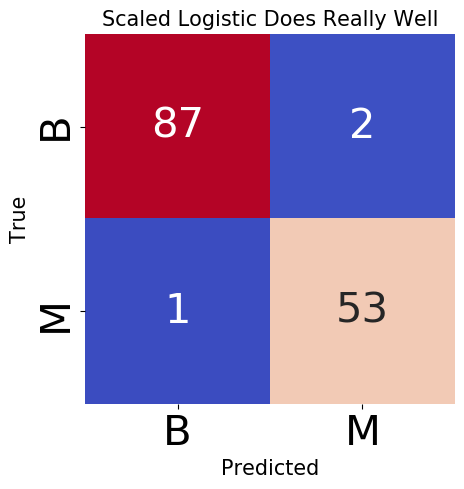

<Figure size 640x480 with 0 Axes>

In [290]:
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, ax=ax, annot=True,  square=True, 
            cbar=False, cmap="coolwarm", fmt='g',
            xticklabels=['B', 'M'],yticklabels=['B', 'M'] )

ax.set_xlabel('Predicted', fontdict={'size': 15})
ax.set_ylabel('True', fontdict={'size': 15})


ax.set_title('Scaled Logistic Does Really Well', fontdict={'size': 15} )
plt.show()
plt.tight_layout();

Even though hyperparameter tuning will have dimishing returns in this scenario, let's see if we can do any better.

Let's cycle through C values, and pick the best value based on accuracy.

In [291]:
c_candidates = np.linspace(1,1000, 500)

c_accuracies = {}
for c in c_candidates:
    
    log_reg = LogisticRegression(C=c, solver='lbfgs', max_iter=400)
    log_reg.fit(X_train_scaled, y_train)
    c_accuracies[c] = log_reg.score(X_test_scaled, y_test)

In [292]:

sorted(c_accuracies.items(), key=lambda kv: kv[1], reverse=True)[:10]

[(1.0, 0.9790209790209791),
 (3.002004008016032, 0.9790209790209791),
 (5.004008016032064, 0.972027972027972),
 (7.006012024048097, 0.972027972027972),
 (9.008016032064129, 0.972027972027972),
 (11.01002004008016, 0.972027972027972),
 (13.012024048096194, 0.972027972027972),
 (15.014028056112226, 0.972027972027972),
 (17.016032064128257, 0.972027972027972),
 (19.01803607214429, 0.972027972027972)]

In [293]:
# Zero in on lower values:

c_smaller = np.linspace(.01,3, 100)
c_smaller_accuracies = {}
for c in c_smaller:
    log_reg = LogisticRegression(C=c, solver='lbfgs', max_iter=400)
    log_reg.fit(X_train_scaled, y_train)
    c_smaller_accuracies[c] = log_reg.score(X_test_scaled, y_test)

In [294]:
sorted(c_smaller_accuracies.items(), key=lambda kv: kv[1], reverse=True)[:10]

[(0.22141414141414145, 0.993006993006993),
 (0.2516161616161616, 0.993006993006993),
 (0.28181818181818186, 0.993006993006993),
 (0.3120202020202021, 0.993006993006993),
 (0.34222222222222226, 0.993006993006993),
 (0.3724242424242425, 0.993006993006993),
 (0.40262626262626267, 0.993006993006993),
 (0.040202020202020204, 0.986013986013986),
 (0.07040404040404041, 0.986013986013986),
 (0.10060606060606062, 0.986013986013986)]

In [295]:
best_c = sorted(c_smaller_accuracies.items(), key=lambda kv: kv[1], reverse=True)[0]
best_c[0]

0.22141414141414145

In [296]:
best_c = sorted(c_smaller_accuracies.items(), key=lambda kv: kv[1], reverse=True)[0]
log_reg = LogisticRegression(C=best_c[0], solver='lbfgs', max_iter=400)
log_reg.fit(X_train_scaled, y_train)
log_reg.score(X_test_scaled, y_test)

0.993006993006993

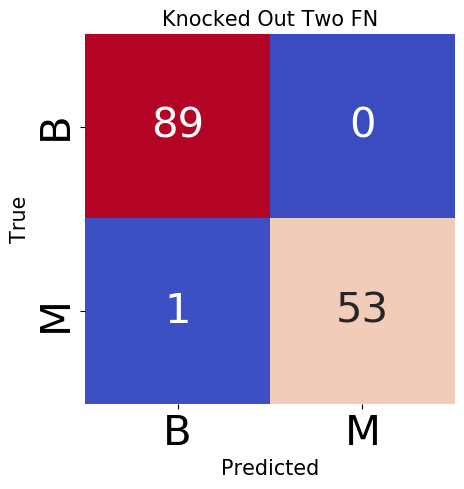

<Figure size 640x480 with 0 Axes>

In [304]:
y_hat = log_reg.predict(X_test_scaled)
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, ax=ax, annot=True,  square=True, 
            cbar=False, cmap="coolwarm", fmt='g',
            xticklabels=['B', 'M'],yticklabels=['B', 'M'] )

ax.set_xlabel('Predicted', fontdict={'size': 15})
ax.set_ylabel('True', fontdict={'size': 15})


ax.set_title('Knocked Out Two FN', fontdict={'size': 15} )
plt.show()
plt.tight_layout();

In [299]:
beta_values = {name:coef for name, coef in zip(list(X_test.columns), list(log_reg.coef_[0]))}
col = [item[0] for item in sorted(beta_values.items(), key= lambda kv: kv[1], reverse=True)]
beta = [item[1] for item in sorted(beta_values.items(), key= lambda kv: kv[1], reverse=True)]
# col_p = [item[0] for item in sorted(beta_values.items(), key= lambda kv: kv[1])][6:]
# beta_p = [item[1] for item in sorted(beta_values.items(), key= lambda kv: kv[1])][6:]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


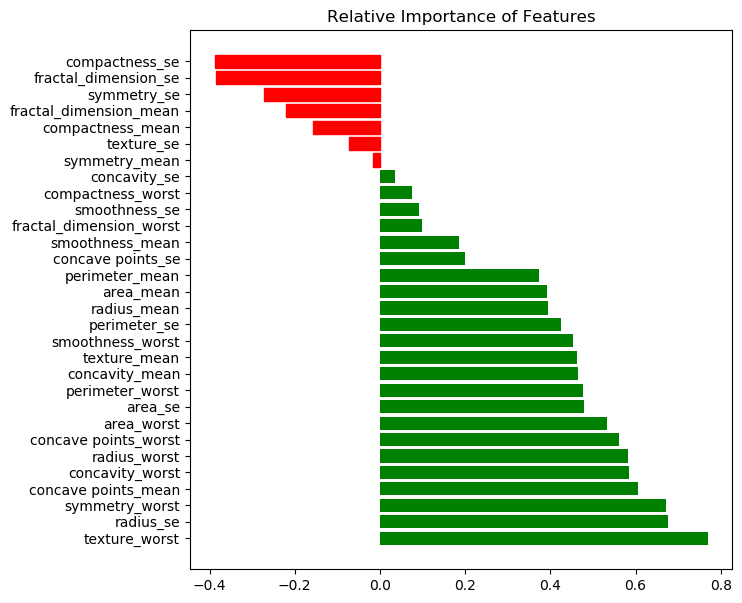

In [313]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

bars = ax.barh(col,beta, color='g')
  
for bar in range(1,8):
    bars[-bar].set_color('red')

ax.set_title('Relative Importance of Features');

In [331]:
# Let's look at the one value our predictor got wrong
y_test[y_test != y_hat]

id
859983    1
Name: Target, dtype: int64

In [356]:
X_test_scaled.loc[y_test[y_test != y_hat].index[0]][['texture_worst', 'radius_se', 'symmetry_worst']]

texture_worst    -0.771919
radius_se        -0.431209
symmetry_worst   -0.469835
Name: 859983, dtype: float64

In [357]:
X_test_scaled[y_test==1].mean()[['texture_worst', 'radius_se', 'symmetry_worst']]

texture_worst     0.696082
radius_se         0.763464
symmetry_worst    0.589979
dtype: float64

In [360]:
X_test_scaled[y_test==1].std()[['texture_worst', 'radius_se', 'symmetry_worst']]

texture_worst     1.046093
radius_se         0.901337
symmetry_worst    1.200149
dtype: float64

In [358]:
X_test_scaled.loc[y_test[y_test != y_hat].index[0]][['compactness_se', 'fractal_dimension_se']]

compactness_se         -0.259049
fractal_dimension_se   -0.243363
Name: 859983, dtype: float64

In [361]:
X_test_scaled[y_test==1].mean()[['compactness_se', 'fractal_dimension_se']]

compactness_se          0.487496
fractal_dimension_se    0.211335
dtype: float64

In [77]:
log_reg.predict_proba([X_test_scaled.loc[y_test[y_test != y_hat].index[0]]])

array([[0.85538625, 0.14461375]])

Our model was very confident about the negative prediction for our one prediction error.


# 8. Assumptions of Logistic Regression

Logistic regression does not make many of the key assumptions of linear regression and general linear models that are based on ordinary least squares algorithms – particularly regarding linearity, normality, and homoscedasticity.

First, logistic regression does not require a linear relationship between the dependent and independent variables.  Second, the error terms (residuals) do not need to be normally distributed.  Third, homoscedasticity is not required.  

**The following assumptions still apply:**

1.  Binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal.

2. Logistic regression requires the observations to be independent of each other.  In other words, the observations should not come from repeated measurements or matched data.

3. Logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other.

4. Logistic regression assumes linearity of independent variables and log odds.  although this analysis does not require the dependent and independent variables to be related linearly, it requires that the independent variables are linearly related to the log odds.

5. Logistic regression typically requires a large sample size.  A general guideline is that you need at minimum of 10 cases with the least frequent outcome for each independent variable in your model. For example, if you have 5 independent variables and the expected probability of your least frequent outcome is .10, then you would need a minimum sample size of 500 (10*5 / .10).

# Appendix: Kfolds

In [368]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=42)

In [381]:
from sklearn.model_selection import KFold 


c_recall = {}

kf = KFold(n_splits=4)

for c in np.linspace(.01,1,100):
    mean_recall = []
    for train_ind, val_ind in kf.split(X_train, y_train):

        X_tt, y_tt = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
        ss = StandardScaler()
        X_tt = ss.fit_transform(X_tt)
        X_val = ss.transform(X_val)
        log_reg = LogisticRegression(C=c, solver='lbfgs', max_iter=400)
        log_reg.fit(X_tt, y_tt)
        mean_recall.append(log_reg.score(X_val, y_val))
        
    c_recall[c] = np.mean(mean_recall)




In [383]:
# diminishing returns
sorted(c_recall.items(), key= lambda kf: kf[1], reverse=True)[0]

(0.09999999999999999, 0.9765253041791571)

# Appendix: Converting sigmoid to log-odds.

If we substitute the product of our linear equation for x in the function above, and rephrase the objective of logistic regression as computing the probability of a class (assume positive class 1) given a set of $\beta$ parameters, our formula becomes:

$$\Large P(Class = 1|X = x) =  \frac{1}{1+e^{-(\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n)}} $$



Now, with some arithmetic:

You can show that, by multiplying both numerator and denominator by $e^{(\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n)}$


$$ \Large P(G = 1|X = x) = \displaystyle \frac{e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n}}{1+e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n}}$$

As a result, you can compute:

$$ \Large P(G = 0|X =x) = 1- \displaystyle \frac{e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n}}{1+e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n}}= \displaystyle \frac{1}{1+e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n}}$$


Further:

$$ \Large \dfrac{ P(G = 1|X = x) }{P(G = 0|X =x)} = e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n} $$

This expression can be interpreted as the *odds in favor of class 1*.  

## Probability and odds

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

This expression can be interpreted as the *odds in favor of class 1*.  

$$ \Large \dfrac{ P(G = 1|X = x) }{P(G = 0|X =x)} = e^{\hat \beta_o+\hat \beta_1 x_1 + \hat \beta_2 x_2...\hat\beta_n x_n} $$



Finally, taking the log of both sides leads to:
<br><br>
    $\ln{\dfrac{ P(G = 1|X = x) }{P(G = 0|X =x)}} = \beta_0 + \beta_1*X_1 + \beta_2*X_2...\beta_n*X_n$
    
Here me can see why we call it logisitic regression.

Our linear function calculates the log of the probability we predict 1, divided by the probability of predicting 0.  In other words, the linear equation is calculating the **log of the odds** that we predict a class of 1.
    